In [ ]:
"""
This script imports essential Python libraries commonly used for data science, machine learning, 
and deep learning workflows, including numerical computing (numpy), data manipulation (pandas), 
deep learning frameworks (PyTorch), image processing (Pillow), progress visualization (tqdm), 
and plotting (matplotlib). It also includes utility modules for randomization, timing, math operations, 
and working with CSV files and dates.

Additionally, it imports specific PyTorch submodules for neural network layers, functional APIs, 
optimization algorithms, and utilities for sequence padding and data loading. The Weights & Biases (wandb) 
library is imported for experiment tracking and model monitoring.

The script prints the versions of the key libraries to verify the environment setup, ensuring compatibility 
and reproducibility. Finally, it logs into the wandb service using an API key for experiment tracking.
"""
import numpy as np
import pandas as pd
import torch
import random
import time
import math
import csv
from PIL import Image
import io
from tqdm import tqdm
from tqdm import __version__ as tqdm_version
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import ConnectionPatch
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F
import copy
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import wandb

print("Versions:")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"torch: {torch.__version__}")
print(f"PIL (Pillow): {Image.__version__}")
print(f"tqdm: {tqdm_version}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"wandb: {wandb.__version__}")

wandb.login(key='5df7feeffbc5b918c8947f5fe4bab4b67ebfbb69')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/indramandal/.netrc


Versions:
numpy: 2.0.2
pandas: 2.2.3
torch: 2.7.0
PIL (Pillow): 11.2.1
tqdm: 4.67.1
matplotlib: 3.9.4
wandb: 0.19.11


True

### Setting File Paths for Dataset
This cell defines the file paths for the training, development, and test datasets. The datasets are part of the Dakshina dataset and are stored locally in .tsv format. These paths are used for loading data for preprocessing and model training.

In [ ]:
"""
This code snippet defines file paths to three key datasets used in a transliteration task for the Bengali language. 
Each variable (`train_df`, `dev_df`, `test_df`) holds the location of a TSV (Tab-Separated Values) file that contains 
sampled lexical entries for training, development (validation), and testing phases respectively. 

These datasets are part of the Dakshina dataset v1.0 collection, which is designed for Indian language transliteration research. 
Specifically, the files contain Bengali text and its transliterated counterparts, enabling supervised learning models to 
learn how to convert Bengali script into Latin script (or vice versa).

By organizing the dataset paths explicitly, this setup facilitates streamlined loading, preprocessing, and evaluation of 
transliteration models in a consistent and reproducible manner.
"""

train_df =('/Users/indramandal/Documents/VS_CODE/DA6401/DA6401_Assignment_3/predictions_attention/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv')
dev_df = ('/Users/indramandal/Documents/VS_CODE/DA6401/DA6401_Assignment_3/predictions_attention/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv')
test_df = ('/Users/indramandal/Documents/VS_CODE/DA6401/DA6401_Assignment_3/predictions_attention/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv')


### Data Preprocessing Class for Sequence-to-Sequence Tasks
This cell defines a class SequenceDataPreprocessor that:

- Reads data from the provided file paths.
- Tokenizes input and target sequences.
- Builds vocabularies including special tokens like <sos>, <eos>, <pad>, and <unk>.
- Encodes sequences into tensors.
- Pads sequences to form uniform tensor batches.
- The class prepares the data for input into a sequence-to-sequence model.

In [ ]:

"""
SequenceDataPreprocessor: A clean and modular data preparation class for sequence-to-sequence models.

This class streamlines the loading, tokenization, vocabulary creation, encoding, and padding of paired
input-target sequence data for NLP tasks like transliteration or translation.

Key Features:
- Special tokens: <sos>, <eos>, <pad>, <unk> are handled automatically.
- Reads TSV-format data with columns: target, input, count.
- Builds token vocabularies if not provided.
- Encodes character sequences into tensors using token-to-index mappings.
- Pads variable-length sequences for efficient batch training.

Returns:
- Padded input and target tensors
- Input and output vocabularies as token-to-index mappings

Usage:
    preprocessor = SequenceDataPreprocessor(path="data.tsv")
    input_tensor, target_tensor, input_vocab, output_vocab = preprocessor.prepare_tensors()
"""


# Special tokens
SOS = '<sos>'
EOS = '<eos>'
PAD = '<pad>'
UNK = '<unk>'

class SequenceDataPreprocessor:
    def __init__(self, path, input_vocab=None, output_vocab=None):
        self.path = path
        self.input_token_to_idx = input_vocab
        self.output_token_to_idx = output_vocab

    def read_data(self, file_path):
        df = pd.read_csv(file_path, sep="\t", names=["target", "input", "count"]).astype(str)
        inputs, outputs = [], []
        for _, row in df.iterrows():
            inp = list(row['input'])
            out = [SOS] + list(row['target']) + [EOS]
            inputs.append(inp)
            outputs.append(out)
        return inputs, outputs

    def build_vocab(self, sequences):
        all_tokens = [token for seq in sequences for token in seq]
        counts = Counter(all_tokens)

        specials_list = [PAD, SOS, EOS, UNK]
        for token in specials_list:
            counts[token] = counts.get(token, 1)

        normal_tokens = sorted([tok for tok in counts if tok not in specials_list])
        tokens = specials_list + normal_tokens

        return {token: idx for idx, token in enumerate(tokens)}

    def encode_sequences(self, sequences, vocab):
        unk_idx = vocab.get(UNK, vocab.get(PAD, 0))  # Fallback
        return [torch.tensor([vocab.get(token, unk_idx) for token in seq], dtype=torch.long) for seq in sequences]

    def pad_batch(self, batch, pad_idx):
        return pad_sequence(batch, batch_first=True, padding_value=pad_idx)

    def prepare_tensors(self):
        inputs, targets = self.read_data(self.path)

        # Build vocab if not provided
        if self.input_token_to_idx is None:
            self.input_token_to_idx = self.build_vocab(inputs)
        if self.output_token_to_idx is None:
            self.output_token_to_idx = self.build_vocab(targets)

        # Check PAD is in vocab
        if PAD not in self.input_token_to_idx or PAD not in self.output_token_to_idx:
            raise ValueError("PAD token not found in vocab. Ensure special tokens are added in build_vocab.")

        input_ids = self.encode_sequences(inputs, self.input_token_to_idx)
        target_ids = self.encode_sequences(targets, self.output_token_to_idx)

        input_tensor = self.pad_batch(input_ids, self.input_token_to_idx[PAD])
        target_tensor = self.pad_batch(target_ids, self.output_token_to_idx[PAD])

        return input_tensor, target_tensor, self.input_token_to_idx, self.output_token_to_idx


In [ ]:
"""
Custom PyTorch Dataset class for sequence-to-sequence models.

This class wraps input and target tensors into a PyTorch-compatible Dataset object, 
allowing use with DataLoader for efficient batching, shuffling, and sampling.

Args:
    input_tensor (torch.Tensor): Tensor containing input sequences (e.g., tokenized source sentences).
    target_tensor (torch.Tensor): Tensor containing target sequences (e.g., tokenized target sentences).

Methods:
    __len__: Returns the total number of samples in the dataset.
    __getitem__: Returns a tuple of (input_tensor[idx], target_tensor[idx]) for a given index.

Example:
    dataset = Datasets(input_tensor, target_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
"""

class Datasets(Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor

    def __len__(self):
        return self.input_tensor.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.input_tensor[idx], self.target_tensor[idx]


In [ ]:
class AccuracyCalculator:
    def __init__(self, eos_token: str, pad_token: str, vocab_out: dict, device: torch.device):
        """
    This class provides a robust and efficient way to calculate accuracy metrics 
    for sequence prediction tasks in PyTorch. It handles special tokens such as 
    <eos> (end of sequence) and <pad> (padding), allowing precise trimming and 
    comparison of sequences.

    Key functionalities include:
    - Initialization with vocabulary indices for <eos> and <pad>, and device setup.
    - Trimming sequences at the first occurrence of <eos> token, ensuring that 
      comparisons only consider relevant parts of predictions and targets.
    - Computing two types of accuracy:
        1) Character-level accuracy: compares individual tokens while ignoring padding.
        2) Sequence-level accuracy: verifies if entire trimmed sequences match exactly.
    - Returns detailed statistics such as counts of correct sequences and characters,
      total sequences and characters, alongside the calculated accuracies.

    This implementation is uniquely crafted to work seamlessly with batched tensors, 
    supporting GPU acceleration via device management, and ensuring flexibility for 
    various sequence lengths through dynamic trimming and padding.
    """

        """
        eos_token: the string for <eos>
        pad_token: the string for <pad>
        vocab_out: token->index mapping for your output vocab
        device:     torch.device (e.g. 'cuda' or 'cpu')
        """
        self.device = device
        self.eos_idx = vocab_out[eos_token]
        self.pad_idx = vocab_out[pad_token]

    def _trim_batch_at_eos(self, sequences: torch.LongTensor):
        """
        sequences: (batch_size, seq_len)
        Returns: list of 1D LongTensors, each trimmed to include its first <eos> (if any),
                 or the full length if no <eos> appears.
        """
        batch_size, seq_len = sequences.size()
        trimmed = []
        # move to CPU & numpy for easy indexing
        seqs = sequences.detach().cpu().tolist()
        for seq in seqs:
            if self.eos_idx in seq:
                end = seq.index(self.eos_idx) + 1
                trimmed.append(torch.tensor(seq[:end], dtype=torch.long, device=self.device))
            else:
                trimmed.append(torch.tensor(seq, dtype=torch.long, device=self.device))
        return trimmed

    def compute_accuracy(self,
                         predictions: torch.LongTensor,
                         targets:     torch.LongTensor
                         ) -> dict:
        """
        predictions: (batch_size, seq_len) of token-indices, already argmaxed
        targets:     (batch_size, seq_len) of token-indices, contains <sos>…<eos> and padding
        """
        predictions = predictions.to(self.device)
        targets     = targets.to(self.device)

        batch_size, seq_len = targets.shape

        # Ensure predictions and targets have the same length by trimming or padding predictions
        if predictions.size(1) > seq_len:
            predictions = predictions[:, :seq_len]
        elif predictions.size(1) < seq_len:
            pad_len = seq_len - predictions.size(1)
            padding = torch.full((predictions.size(0), pad_len), self.pad_idx, dtype=predictions.dtype, device=predictions.device)
            predictions = torch.cat([predictions, padding], dim=1)

        # 1) Character-level accuracy (ignoring PAD completely)
        nonpad_mask   = targets != self.pad_idx                # (B, L) bool
        char_correct  = ((predictions == targets) & nonpad_mask).sum().item()
        char_total    = nonpad_mask.sum().item()
        char_accuracy = char_correct / char_total if char_total > 0 else 0.0

        # 2) Sequence-level accuracy
        #    Trim both preds & targets at each target's <eos>, then compare exactly.
        pred_trimmed = self._trim_batch_at_eos(predictions)
        targ_trimmed = self._trim_batch_at_eos(targets)

        seq_correct = 0
        for p_seq, t_seq in zip(pred_trimmed, targ_trimmed):
            if p_seq.size(0) == t_seq.size(0) and torch.equal(p_seq, t_seq):
                seq_correct += 1

        seq_accuracy = seq_correct / batch_size if batch_size > 0 else 0.0

        return {
            'sequence_accuracy':   seq_accuracy,
            'character_accuracy':  char_accuracy,
            'correct_sequences':   seq_correct,
            'total_sequences':     batch_size,
            'correct_characters':  char_correct,
            'total_characters':    char_total
        }


In [ ]:
class Encoder(nn.Module):
    """
    This Encoder class implements a flexible recurrent neural network module for sequence encoding, 
    suitable for use in sequence-to-sequence models such as machine translation or text summarization. 

    Key features include:
    - Embedding Layer: Converts input token indices into dense vector representations, handling padding tokens gracefully.
    - Configurable Recurrent Layer: Supports RNN, LSTM, or GRU units selectable via the `layer_type` parameter.
    - Multi-layer Support: Allows stacking multiple recurrent layers (`num_encod_layers`) with optional dropout to prevent overfitting.
    - Bidirectionality Option: Can process input sequences in both forward and backward directions, enhancing context capture.
    - Flexible Forward Pass: Returns encoded outputs along with hidden (and cell for LSTM) states for downstream tasks.

    The class encapsulates both embedding and recurrent computations, enabling end-to-end learning of sequence representations 
    in a modular and extensible manner.
    """

    def __init__(self, input_size, layer_type, emb_dim, hidden_layers_size, num_encod_layers, dropout_rate, pad_index, bidirectional=False):
        super().__init__()
        self.layer_type = layer_type
        self.layers = self.layer_mode(layer_type)
        self.bidirectional = bidirectional
        self.num_encod_layers = num_encod_layers
        self.hidden_size = hidden_layers_size

        self.embed = nn.Embedding(input_size, emb_dim, padding_idx=pad_index)
        self.layer = self.layers(
            emb_dim, 
            hidden_layers_size, 
            num_encod_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_encod_layers > 1 else 0
        )

    def layer_mode(self, layer_type):
        layer_type = layer_type.lower()
        if layer_type == "rnn":
            return nn.RNN
        elif layer_type == "lstm":
            return nn.LSTM
        else:
            return nn.GRU

    def forward(self, input_seq):
        embed = self.embed(input_seq)
        if self.layer_type == "lstm":
            outputs, (hidden, cell) = self.layer(embed)
        else:
            outputs, hidden = self.layer(embed)
            cell = None
        return outputs, hidden, cell

In [ ]:
class Attention(nn.Module):
    """
    This class implements a versatile attention mechanism module compatible with
    sequence-to-sequence models, supporting three widely used attention methods:
    'Luong_dot', 'Luong_general', and 'Bahdanau_concat'. Attention helps the
    decoder selectively focus on relevant parts of the encoder outputs during
    decoding, improving context awareness and performance in tasks like machine
    translation or speech recognition.

    Initialization:
    - method (str): Specifies which attention type to use.
      * 'Luong_dot' uses simple dot product between decoder hidden state and encoder outputs.
      * 'Luong_general' applies a learned linear transformation on encoder outputs before dot product.
      * 'Bahdanau_concat' concatenates decoder hidden state and encoder outputs, applies
        a learned feedforward network with a tanh activation and scores the result.
    - encoder_hidden_size (int): Dimensionality of encoder hidden states.
    - decoder_hidden_size (int): Dimensionality of decoder hidden states.

    Forward Pass:
    - Inputs:
        * decoder_hidden: Tensor of shape (batch_size, decoder_hidden_size), the current decoder hidden state.
        * encoder_outputs: Tensor of shape (batch_size, src_len, encoder_hidden_size), all encoder hidden states.
    - Processing:
        * Computes attention scores based on the chosen method.
        * Normalizes scores with softmax to obtain attention weights.
        * Computes a weighted sum (context vector) of encoder outputs using these weights.
    - Outputs:
        * context: Tensor of shape (batch_size, encoder_hidden_size), the attention-weighted context vector.
        * attention_weights: Tensor of shape (batch_size, src_len), representing the alignment between decoder state and encoder outputs.

    This modular and flexible design enables seamless integration into
    various encoder-decoder architectures, facilitating improved
    sequence modeling by dynamically highlighting relevant encoded information.
    """

    def __init__(self, method, encoder_hidden_size, decoder_hidden_size):
        super().__init__()
        self.method = method
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        
        if self.method == 'Luong_general':
            self.Wa = nn.Linear(encoder_hidden_size, decoder_hidden_size, bias=False)
        elif self.method == 'Bahdanau_concat':
            self.Wa = nn.Linear(encoder_hidden_size + decoder_hidden_size, decoder_hidden_size)
            self.v = nn.Linear(decoder_hidden_size, 1, bias=False)
        elif self.method != 'Luong_dot':
            raise ValueError("Invalid attention method")
    
    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (batch_size, decoder_hidden_size)
        # encoder_outputs: (batch_size, src_len, encoder_hidden_size)
        
        if self.method == 'Luong_dot':
            scores = torch.bmm(encoder_outputs, decoder_hidden.unsqueeze(2)).squeeze(2)
        elif self.method == 'Luong_general':
            transformed_encoder = self.Wa(encoder_outputs)
            scores = torch.bmm(transformed_encoder, decoder_hidden.unsqueeze(2)).squeeze(2)
        elif self.method == 'Bahdanau_concat':
            decoder_hidden_expanded = decoder_hidden.unsqueeze(1).expand(-1, encoder_outputs.size(1), -1)
            combined = torch.cat([decoder_hidden_expanded, encoder_outputs], dim=2)
            energy = torch.tanh(self.Wa(combined))
            scores = self.v(energy).squeeze(2)
        
        attention_weights = F.softmax(scores, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attention_weights


In [ ]:
class Decoder(nn.Module):
    """
    This Decoder class implements a flexible recurrent neural network decoder module
    designed for sequence-to-sequence models with attention mechanisms. It supports
    multiple RNN variants (RNN, LSTM, or GRU), configurable number of layers, and
    optional bidirectionality. The decoder uses an embedding layer to convert input
    token indices into dense vectors, which are then concatenated with a context
    vector computed via an attention mechanism over encoder outputs.

    Key features include:
    - Attention integration (e.g., Luong general method) to dynamically focus on relevant
      parts of the encoder outputs for each decoding step.
    - Support for different recurrent layer types selectable via the `layer_type` parameter.
    - Handling of bidirectional encoder hidden states by concatenating forward and backward
      outputs to create the decoder’s context vector.
    - Dropout regularization applied between decoder layers when multiple layers are used.
    - Outputs at each step are passed through a fully connected layer to predict the
      next token in the target sequence.
    
    Inputs:
    - `inputs`: current decoder input token indices.
    - `hidden`: hidden states from the previous decoder step.
    - `encoder_outputs`: sequence of encoder hidden states for attention.
    - `cell`: LSTM cell states (optional, used only for LSTM).

    Outputs:
    - Predicted token scores (logits).
    - Updated hidden and cell states.
    - Attention weights reflecting focus over encoder outputs.

    This implementation provides a clean, modular, and extensible decoder suitable for
    diverse seq2seq tasks such as machine translation, summarization, or conversational AI.
    """

    def __init__(self, input_size, output_size, layer_type, emb_dim, hidden_layers_size,
                 num_decod_layers, dropout_rate, pad_index, encoder_hidden_size, 
                 bidirectional=False, attention_method='Luong_general'):
        super().__init__()
        self.layer_type = layer_type.lower()
        self.bidirectional = bidirectional
        self.num_layers = num_decod_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.attention_method = attention_method
        self.hidden_size = hidden_layers_size

        self.embed = nn.Embedding(input_size, emb_dim, padding_idx=pad_index)
        
        # Attention layer
        self.attention = Attention(
            method=attention_method,
            encoder_hidden_size=encoder_hidden_size,
            decoder_hidden_size=hidden_layers_size * (2 if bidirectional else 1)
        )
        
        # RNN input size: emb_dim + encoder_hidden_size (context)
        rnn_input_size = emb_dim + encoder_hidden_size
        
        rnn_cls = self.layer_mode(self.layer_type)
        self.layer = rnn_cls(
            rnn_input_size,
            hidden_layers_size,
            num_decod_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_decod_layers > 1 else 0
        )
        
        rnn_output_dim = hidden_layers_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(rnn_output_dim, output_size)

    def layer_mode(self, layer_type):
        if layer_type == "rnn":
            return nn.RNN
        elif layer_type == "lstm":
            return nn.LSTM
        else:
            return nn.GRU

    def forward(self, inputs: torch.LongTensor, hidden, encoder_outputs, cell=None):
        inputs = inputs.unsqueeze(1)  # (batch, 1)
        embed = self.embed(inputs)     # (batch, 1, emb_dim)
        
        # Prepare decoder hidden state for attention
        if self.bidirectional:
            # Reshape for multi-layer bidirectionality
            hidden_reshaped = hidden.view(
                self.num_layers, 2,  # (num_layers, num_directions)
                -1,                  # Batch size
                self.hidden_size
            )
            # Concatenate last layer's forward/backward states
            hidden_combined = torch.cat([
                hidden_reshaped[-1, 0, :, :],  # Forward direction
                hidden_reshaped[-1, 1, :, :]   # Backward direction
            ], dim=1)
        else:
            hidden_combined = hidden[-1]  # (batch_size, hidden_size)
        
        context, attn_weights = self.attention(hidden_combined, encoder_outputs)
        context = context.unsqueeze(1)
        rnn_input = torch.cat([embed, context], dim=2)
        
        if self.layer_type == "lstm":
            outputs, (hidden, cell) = self.layer(rnn_input, (hidden, cell))
        else:
            outputs, hidden = self.layer(rnn_input, hidden)
            cell = None
        
        predict_word = self.fc(outputs.squeeze(1))
        return predict_word, hidden, cell, attn_weights  # Return attention weights

    


In [ ]:
class Sequence2Sequence(nn.Module):
    """
    This class `Sequence2Sequence` defines a flexible and extensible sequence-to-sequence neural network model built using PyTorch's `nn.Module`. It encapsulates the core components of an encoder-decoder architecture commonly used for tasks such as machine translation, text summarization, and other sequence transduction problems.

    Key features include:
    - **Encoder and Decoder Integration**: The model accepts separately defined encoder and decoder modules, allowing for versatile architecture design and easy swapping of different RNN variants (LSTM, GRU, etc.).
    - **Hidden State Adjustment**: It includes a utility method `adjust_hidden` that reshapes or pads the hidden and cell states to match the decoder’s expected number of layers, supporting mismatches between encoder and decoder layer counts and directionalities.
    - **Teacher Forcing in Forward Pass**: The `forward` method implements standard teacher forcing where the decoder is fed ground truth tokens probabilistically during training, improving learning stability.
    - **Attention Support**: Optionally returns attention weights computed during decoding to facilitate interpretability or downstream use.
    - **Beam Search Decoding**: Provides a `beam_search_decode` method for generating high-quality output sequences at inference by exploring multiple candidate sequences simultaneously, improving over greedy decoding.
    - **Bidirectionality and Layer Flexibility**: Correctly handles the complexities introduced by bidirectional RNNs and multi-layered encoders/decoders, adjusting hidden state dimensions accordingly.
    - **Modular and Clean Design**: The class emphasizes clarity and modularity, making it easy to maintain, extend, or integrate into larger pipelines.

    Overall, this implementation balances usability, flexibility, and functionality, making it a practical foundation for advanced sequence modeling tasks.
    """


    def __init__(self, encoder, decoder, output_vocab):
        super().__init__()
        self.output_vocab = output_vocab
        self.encoder = encoder
        self.decoder = decoder
        self.layer_type = encoder.layer_type.lower()

    def adjust_hidden(self, hidden, desired_layers):
        current_layers = hidden.size(0)
        if current_layers < desired_layers:
            zeros = torch.zeros(desired_layers - current_layers, 
                                hidden.size(1), 
                                hidden.size(2),
                                device=hidden.device,
                                dtype=hidden.dtype)
            adjusted = torch.cat([hidden, zeros], dim=0)
        else:
            adjusted = hidden[:desired_layers]
        return adjusted

    def forward(self, input_sequence, target_sequence, teacher_force_ratio=0.5, return_attention=False):
        batch_size = input_sequence.size(0)
        target_len = target_sequence.size(1)
        vocab_size = len(self.output_vocab)
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(input_sequence.device)
        
        # Encoder forward
        encoder_outputs, hidden, cell = self.encoder(input_sequence)

        # Adjust hidden states for decoder
        encoder_directions = 2 if self.encoder.bidirectional else 1
        decoder_directions = 2 if self.decoder.bidirectional else 1
        encoder_total = self.encoder.num_encod_layers * encoder_directions
        decoder_total = self.decoder.num_layers * decoder_directions

        hidden = self.adjust_hidden(hidden, decoder_total)
        cell = self.adjust_hidden(cell, decoder_total) if cell is not None else None
        
        x = target_sequence[:, 0]
        attentions = [] if return_attention else None

        for t in range(1, target_len):
            output, hidden, cell, attn_weights = self.decoder(x, hidden, encoder_outputs, cell)
            outputs[:, t] = output
            if return_attention:
                attentions.append(attn_weights)
            x = target_sequence[:, t] if random.random() < teacher_force_ratio else output.argmax(1)

        if return_attention:
            return outputs, attentions
        return outputs

    def beam_search_decode(self, input_sequence, sos_token, eos_token, beam_width=3, max_len=30):
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            device = input_sequence.device
            encoder_outputs, hidden, cell = self.encoder(input_sequence)

            # Adjust hidden dimensions
            encoder_directions = 2 if self.encoder.bidirectional else 1
            decoder_directions = 2 if self.decoder.bidirectional else 1
            encoder_total = self.encoder.num_encod_layers * encoder_directions
            decoder_total = self.decoder.num_layers * decoder_directions

            hidden = self.adjust_hidden(hidden, decoder_total)
            cell = self.adjust_hidden(cell, decoder_total) if cell is not None else None

            # Initial beams
            beams = [([sos_token], 0.0, hidden, cell)]
            completed_sequences = []

            for _ in range(max_len):
                temp_beams = []
                for seq, score, h, c in beams:
                    if seq[-1] == eos_token:
                        completed_sequences.append((seq, score))
                        continue

                    last_token = torch.LongTensor([seq[-1]]).to(device)
                    out, h_new, c_new, _ = self.decoder(last_token, h, encoder_outputs, c)
                    log_probs = torch.log_softmax(out, dim=1)
                    top_log_probs, top_indices = torch.topk(log_probs, beam_width)

                    for i in range(beam_width):
                        token = top_indices[0][i].item()
                        new_seq = seq + [token]
                        new_score = score + top_log_probs[0][i].item()
                        temp_beams.append((new_seq, new_score, h_new, c_new))

                beams = sorted(temp_beams, key=lambda x: x[1], reverse=True)[:beam_width]

                if all(seq[-1] == eos_token for seq, _, _, _ in beams):
                    completed_sequences.extend(beams)
                    break

            if not completed_sequences:
                completed_sequences = beams
            best_sequence = max(completed_sequences, key=lambda x: x[1])[0]
            return best_sequence

In [ ]:

class Train_Model:
    """
    This class encapsulates the training routine for a sequence-to-sequence (seq2seq) model 
    designed for tasks such as sequence prediction or translation. It integrates all essential 
    components needed for training: the model, data loader, optimizer, loss function, accuracy 
    calculator, and the device configuration (CPU/GPU).

    Key functionalities include:
    - Parameter counting: Provides a method to count the number of trainable parameters 
      in the seq2seq model, aiding model complexity assessment.
    - Training loop: Implements a robust training process that iterates over batches of input-target 
      pairs, performs forward passes with optional teacher forcing, computes loss and accuracy, 
      backpropagates gradients with clipping to avoid exploding gradients, and updates model parameters.
    - Accuracy metrics: Computes both sequence-level and character-level accuracy while ignoring 
      special start-of-sequence tokens, providing detailed insight into model performance.
    - Progress monitoring: Utilizes tqdm to visually track batch-wise training progress, dynamically 
      displaying current loss and accuracy metrics for immediate feedback.

    This design ensures modularity, clear metric tracking, and efficient training of seq2seq models, 
    making it adaptable for various sequence modeling tasks such as language translation, text 
    generation, or time series prediction.
    """

    def __init__(self, seq2seq, dataloader, optimizer, loss_fn, acc_calculator, device):
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.acc_calculator = acc_calculator
        self.device = device
        self.seq2seq = seq2seq

    def count_params(self,model):
        return sum(param.numel() for param in model.parameters() if param.requires_grad)

    def train(self, teacher_force_ratio=0.5):
        self.seq2seq.to(self.device)
        self.seq2seq.train()

        epoch_loss = 0
        seq_acc = 0
        character_acc = 0
        total_seqs = 0
        total_chars = 0

        progress_bar = tqdm(self.dataloader, desc="Training Batches")

        for input_batch, target_batch in progress_bar:
            input_batch = input_batch.to(self.device)
            target_batch = target_batch.to(self.device)

            self.optimizer.zero_grad()

            output = self.seq2seq(input_batch, target_batch, teacher_force_ratio)
            _, predicted = torch.max(output, dim=2)

            # Calculate accuracy ignoring SOS token
            predicted_trimmed = predicted[:, 1:]
            target_trimmed = target_batch[:, 1:]

            # Flatten for loss calculation
            output_flat = output.view(-1, output.shape[-1])
            target_flat = target_batch.reshape(-1).to(self.device)

            loss = self.loss_fn(output_flat, target_flat)
            acc = self.acc_calculator.compute_accuracy(predicted_trimmed, target_trimmed)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.seq2seq.parameters(), max_norm=1)
            self.optimizer.step()

            epoch_loss += loss.item()
            seq_acc += acc['correct_sequences']
            total_seqs += acc['total_sequences']
            character_acc += acc['correct_characters']
            total_chars += acc['total_characters']

            avg_seq_acc = seq_acc / total_seqs if total_seqs > 0 else 0.0
            avg_char_acc = character_acc / total_chars if total_chars > 0 else 0.0

            progress_bar.set_postfix({
                'Train_loss': loss.item(),
                'seq_acc': f"{avg_seq_acc:.2%}",
                'char_acc': f"{avg_char_acc:.2%}"
            })

        return (epoch_loss / len(self.dataloader), 
                avg_char_acc, 
                avg_seq_acc)

In [ ]:
class Evaluate_Model:
    """
    This class `Evaluate_Model` encapsulates the evaluation process for a sequence-to-sequence (seq2seq) model, 
    providing a clean, modular, and reusable interface to measure model performance on validation or test data.

    Key functionalities:
    - Initialization accepts the seq2seq model, a DataLoader for batching data, a loss function, 
    an accuracy calculator, and the device (CPU/GPU) for computation.
    - The `evaluate` method performs a full evaluation cycle over the dataset with options for:
    - Standard greedy decoding or advanced beam search decoding with configurable beam width.
    - During evaluation, the model is switched to evaluation mode and moved to the specified device.
    - It accumulates loss and two levels of accuracy:
    - Sequence-level accuracy (entire predicted sequences matching targets).
    - Character-level accuracy (individual token correctness across sequences).
    - Handles variable-length predictions by padding or truncating to match target lengths for accurate metrics.
    - Utilizes `torch.no_grad()` for inference efficiency by disabling gradient computation.
    - Displays real-time progress with the `tqdm` progress bar including live loss and accuracy metrics.
    - Returns averaged loss, character accuracy, and sequence accuracy across all batches for robust model assessment.

    This design cleanly separates evaluation logic from training, making it easy to plug into diverse seq2seq projects 
    and supports enhanced decoding strategies like beam search to potentially improve output quality.
    """

    def __init__(self, seq2seq, dataloader, loss_fn, acc_calculator, device):
        self.dataloader = dataloader
        self.loss_fn = loss_fn
        self.acc_calculator = acc_calculator
        self.device = device
        self.seq2seq = seq2seq

    def evaluate(self, beam_search=False, beam_width=3):
        self.seq2seq.eval()
        self.seq2seq.to(self.device)

        epoch_loss = 0
        seq_acc = 0
        character_acc = 0
        total_seqs = 0
        total_chars = 0

        progress_bar = tqdm(self.dataloader, desc="Evaluation Batches")

        with torch.no_grad():
            for input_batch, target_batch in progress_bar:
                input_batch = input_batch.to(self.device)
                target_batch = target_batch.to(self.device)
                
                if beam_search:
                    decoded_batch = []
                    for i in range(input_batch.size(0)):
                        predicted_ids = self.seq2seq.beam_search_decode(
                            input_batch[i].unsqueeze(0),
                            sos_token=self.seq2seq.output_vocab[SOS],
                            eos_token=self.seq2seq.output_vocab[EOS],
                            beam_width=beam_width
                        )
                        decoded_batch.append(torch.tensor(predicted_ids, device=self.device))

                    max_len = max(len(seq) for seq in decoded_batch)
                    predicted_tensor = torch.full((input_batch.size(0), max_len), 
                                      fill_value=self.seq2seq.output_vocab[PAD], 
                                      device=self.device)
                    for i, seq in enumerate(decoded_batch):
                        predicted_tensor[i, :len(seq)] = seq
                else:
                    output = self.seq2seq(input_batch, target_batch, teacher_force_ratio=0)
                    _, predicted = torch.max(output, dim=2)
                    predicted_tensor = predicted

                # Pad/cut predictions to match target length
                predicted_tensor = predicted_tensor[:, :target_batch.size(1)]
                if predicted_tensor.size(1) < target_batch.size(1):
                    pad = torch.full((predicted_tensor.size(0), 
                                    target_batch.size(1) - predicted_tensor.size(1)),
                                    self.seq2seq.output_vocab[PAD], 
                                    device=self.device)
                    predicted_tensor = torch.cat([predicted_tensor, pad], dim=1)

                # Calculate loss
                output = self.seq2seq(input_batch, target_batch, teacher_force_ratio=0)
                output_flat = output.view(-1, output.shape[-1])
                target_flat = target_batch.view(-1)
                loss = self.loss_fn(output_flat, target_flat)

                # Calculate accuracy
                pred_trimmed = predicted_tensor[:, 1:]
                target_trimmed = target_batch[:, 1:]
                acc = self.acc_calculator.compute_accuracy(pred_trimmed, target_trimmed)

                epoch_loss += loss.item()
                seq_acc += acc['correct_sequences']
                total_seqs += acc['total_sequences']
                character_acc += acc['correct_characters']
                total_chars += acc['total_characters']

                avg_seq_acc = seq_acc / total_seqs if total_seqs > 0 else 0.0
                avg_char_acc = character_acc / total_chars if total_chars > 0 else 0.0

                progress_bar.set_postfix({
                    'Val_loss': loss.item(),
                    'seq_acc': f"{avg_seq_acc:.2%}",
                    'char_acc': f"{avg_char_acc:.2%}"
                })

        return (epoch_loss / len(self.dataloader), 
                avg_char_acc, 
                avg_seq_acc)
    

    

In [12]:
# Check if mps is available

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")



Using MPS device


In [13]:
device = torch.device("cpu")

In [14]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

In [ ]:
class Build_Model:
    """
    The Build_Model class serves as a comprehensive framework for constructing, training, validating, and optionally testing 
    a sequence-to-sequence (Seq2Seq) deep learning model with attention mechanisms, tailored for sequence prediction tasks 
    such as language translation or transliteration. 

    Upon initialization, it ingests training and validation datasets, preprocesses them using a user-provided data preprocessor 
    to generate tensor representations and vocabularies, and sets up PyTorch DataLoader objects for efficient batch handling. 

    The core 'build' method enables flexible model configuration, allowing users to specify embedding sizes, recurrent layer types 
    (LSTM, GRU, RNN), number of layers, hidden state dimensions, dropout rates, bidirectionality, and attention methods. It 
    instantiates encoder and decoder networks, integrates them into a Seq2Seq architecture, and prepares an optimizer and 
    loss criterion optimized for sequence tasks with padding support.

    Training incorporates a decaying teacher forcing ratio to gradually transition from ground-truth inputs to model predictions, 
    while validation optionally supports beam search for enhanced sequence decoding. The class includes early stopping with 
    patience control to prevent overfitting, saving the best-performing model checkpoint automatically. 

    A detailed progress report is printed per epoch, including loss and accuracy at both character and sequence levels, and 
    optionally logged to Weights & Biases for experiment tracking. During testing, the model can be evaluated on unseen data 
    with or without beam search, reporting comprehensive metrics.

    Overall, Build_Model abstracts the end-to-end lifecycle of sequence model development, offering modularity, configurability, 
    and robust training and evaluation routines in a clean, readable, and reusable design.
    """

    def __init__(self, 
                 sequence_data_preprocessor,
                 encoder_class, 
                 decoder_class, 
                 seq2seq_class, 
                 attention_class,
                 batch_size,
                 train_path,
                 val_path,
                 device="cpu"):
        
        self.sequence_data_preprocessor = sequence_data_preprocessor
        self.encoder_class = encoder_class
        self.decoder_class = decoder_class
        self.seq2seq_class = seq2seq_class
        self.attention_class = attention_class
        self.batch_size = batch_size
        self.train_path = train_path
        self.val_path = val_path
        self.device = device

        # Process datasets
        train_processor = self.sequence_data_preprocessor(self.train_path)
        self.train_input_tensor, self.train_target_tensor, self.input_vocab, self.output_vocab = train_processor.prepare_tensors()

        val_processor = self.sequence_data_preprocessor(self.val_path, input_vocab=self.input_vocab, output_vocab=self.output_vocab)
        self.val_input_tensor, self.val_target_tensor, _, _ = val_processor.prepare_tensors()

        # Create datasets and dataloaders
        train_data = Datasets(self.train_input_tensor, self.train_target_tensor)
        val_data = Datasets(self.val_input_tensor, self.val_target_tensor)

        self.train_dataloader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        self.val_dataloader = DataLoader(val_data, batch_size=self.batch_size, shuffle=True)

    def epoch_time(self, start_time, end_time):
        elapsed = end_time - start_time
        return int(elapsed // 60), int(elapsed % 60)

    def build(self,
              emb_size, layer_type, hidden_layers_size,
              num_encod_layers, num_decod_layers,
              dropout_rate, epochs, learning_rate,
              teacher_force_ratio=0, bidirectional=False,
              save_path='best_model.pt', patience=3,
              val_beam_search=False, beam_width=3,
              testing_phase=False, test_path=None,
              test_beam_search=False, wandb_log=False,
              attention_method='Luong_general'):
        
        # Instantiate Encoder
        encoder = self.encoder_class(
            input_size=len(self.input_vocab),
            layer_type=layer_type,
            emb_dim=emb_size,
            hidden_layers_size=hidden_layers_size,
            num_encod_layers=num_encod_layers,
            dropout_rate=dropout_rate,
            pad_index=self.input_vocab[PAD],
            bidirectional=bidirectional
        ).to(self.device)

        # Calculate encoder hidden size for attention
        encoder_hidden_size = hidden_layers_size * (2 if bidirectional else 1)

        # Instantiate Decoder with Attention
        decoder = self.decoder_class(
            input_size=len(self.output_vocab),
            output_size=len(self.output_vocab),
            layer_type=layer_type,
            emb_dim=emb_size,
            hidden_layers_size=hidden_layers_size,
            num_decod_layers=num_decod_layers,
            dropout_rate=dropout_rate,
            pad_index=self.output_vocab[PAD],
            encoder_hidden_size=encoder_hidden_size,
            bidirectional=bidirectional,
            attention_method=attention_method
        ).to(self.device)

        # Assemble Seq2Seq Model
        seq2seq = self.seq2seq_class(
            encoder=encoder,
            decoder=decoder,
            output_vocab=self.output_vocab
        ).to(self.device)

        optimizer = optim.Adam(seq2seq.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=self.output_vocab[PAD])

        acc_calculator = AccuracyCalculator(
            eos_token=EOS,
            pad_token=PAD,
            vocab_out=self.output_vocab,
            device=self.device
        )

        train_model = Train_Model(seq2seq, self.train_dataloader, optimizer, criterion, acc_calculator, self.device)
        evaluate_model = Evaluate_Model(seq2seq, self.val_dataloader, criterion, acc_calculator, self.device)

        print(f'The model has {train_model.count_params(seq2seq):,} trainable parameters')

        best_val_loss = float('inf')
        best_model_state = None
        epochs_no_improve = 0

        for epoch in range(epochs):
            start_time = time.time()

            # Decaying teacher forcing ratio
            decay_rate = 0.05
            current_tfr = teacher_force_ratio * np.exp(-decay_rate * epoch)
            current_tfr = max(0.0, current_tfr)

            print(f'\nEpoch {epoch+1}/{epochs} | Teacher Forcing Ratio: {current_tfr:.4f}\n{"-"*80}')
            train_loss, train_char_acc, train_seq_acc = train_model.train(teacher_force_ratio=current_tfr)
            print(f'Train Loss: {train_loss:.4f} | Char Acc: {train_char_acc:.4f} | Seq Acc: {train_seq_acc:.4f}')

            val_loss, val_char_acc, val_seq_acc = evaluate_model.evaluate(beam_search=val_beam_search, beam_width=beam_width)
            print(f'Val   Loss: {val_loss:.4f} | Char Acc: {val_char_acc:.4f} | Seq Acc: {val_seq_acc:.4f}')

            if wandb_log:
                wandb.log({
                    'epoch': epoch + 1,
                    'train_loss': train_loss,
                    'train_char_acc': train_char_acc,
                    'train_seq_acc': train_seq_acc,
                    'val_loss': val_loss,
                    'val_char_acc': val_char_acc,
                    'val_seq_acc': val_seq_acc
                })

            # Early stopping and model saving
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(seq2seq.state_dict())
                best_train_loss = train_loss
                best_train_char_acc = train_char_acc
                best_train_seq_acc = train_seq_acc
                best_val_char_acc = val_char_acc
                best_val_seq_acc = val_seq_acc
                epochs_no_improve = 0
                print("Validation improved.")
            else:
                epochs_no_improve += 1
                print(f'No improvement. Patience counter: {epochs_no_improve}/{patience}')
                if epochs_no_improve >= patience:
                    print(f'Early stopping triggered.')
                    break

            epoch_mins, epoch_secs = self.epoch_time(start_time, time.time())
            print(f"Epoch Time: {epoch_mins}m {epoch_secs}s")

        # Save the best model
        if best_model_state is not None:
            print("Saving best model...")
            torch.save(best_model_state, save_path)
        else:
            print("Saving last model (no improvement).")
            torch.save(seq2seq.state_dict(), save_path)

        # ========== TEST PHASE ==========
        if testing_phase:
            if not test_path:
                raise ValueError("Test path must be provided when testing_phase=True.")
            
            print(f'\n\n{"+"*28}<Testing Phase Started>{"+"*28}\nPreparing test dataset...\n')
            test_processor = self.sequence_data_preprocessor(test_path, input_vocab=self.input_vocab, output_vocab=self.output_vocab)
            test_input_tensor, test_target_tensor, _, _ = test_processor.prepare_tensors()

            test_data = Datasets(test_input_tensor, test_target_tensor)
            test_dataloader = DataLoader(test_data, batch_size=self.batch_size)

            # Load the best model and evaluate
            best_seq2seq = self.seq2seq_class(
                encoder=encoder,
                decoder=decoder,
                output_vocab=self.output_vocab
            ).to(self.device)
            best_seq2seq.load_state_dict(torch.load(save_path))
            best_seq2seq.eval()

            test_eval_model = Evaluate_Model(
                seq2seq=best_seq2seq,
                dataloader=test_dataloader,
                loss_fn=criterion,
                acc_calculator=acc_calculator,
                device=self.device
            )

            test_loss, test_char_acc, test_seq_acc = test_eval_model.evaluate(
                beam_search=test_beam_search, 
                beam_width=beam_width
            )
            print(f'Test Loss: {test_loss:.4f} | Test Char Acc: {test_char_acc:.4f} | Test Seq Acc: {test_seq_acc:.4f}')

        # Final log return
        log = {
            'train_loss': best_train_loss,
            'train_char_acc': best_train_char_acc,
            'train_seq_acc': best_train_seq_acc,
            'val_loss': best_val_loss,
            'val_char_acc': best_val_char_acc,
            'val_seq_acc': best_val_seq_acc
        }

        if testing_phase:
            log.update({
                'test_loss': test_loss, 'test_char_acc': test_char_acc, 'test_seq_acc': test_seq_acc
            })

        model_params = {
            "input_vocab": self.input_vocab,
            "output_vocab": self.output_vocab,
            "emb_size": emb_size,
            "layer_type": layer_type,
            "hidden_layers_size": hidden_layers_size,
            "num_encod_layers": num_encod_layers,
            "num_decod_layers": num_decod_layers,
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "teacher_force_ratio": teacher_force_ratio,
            "bidirectional": bidirectional,
            "beam_width": beam_width,
            "attention_method": attention_method,
            "patience": patience,
            "save_path": save_path
        }

        return seq2seq, train_model, evaluate_model, log, model_params

In [ ]:
"""
This code snippet sets up and trains a sequence-to-sequence (seq2seq) model enhanced with an attention mechanism, enabling improved performance in tasks such as machine translation or transliteration.
Uncommen the below code to run the model.

- **Beam Search Setup:** It initializes a beam search decoding strategy with a beam width of 3. Beam search improves decoding by considering multiple candidate sequences instead of a single greedy path, thereby increasing the likelihood of generating more accurate outputs.

- **Model Initialization:** The `Build_Model` class is instantiated with core components:
  - A data preprocessor tailored for sequential data,
  - Custom encoder and decoder architectures,
  - A seq2seq controller to manage training and inference,
  - An attention mechanism to dynamically focus on relevant parts of the input sequence during decoding.
  Additional parameters include batch size, training and validation datasets, and the target computation device (CPU or GPU).

- **Model Building and Training:** The `build` method configures the model with key hyperparameters such as embedding size, recurrent layer type (GRU here), hidden layer size, number of encoder and decoder layers, dropout for regularization, and learning rate. Teacher forcing is used during training to improve convergence. The model supports bidirectional encoding to capture context from both directions of the input sequence.

- **Validation and Testing:** Early stopping patience and beam search decoding during validation and testing phases can be enabled. Different attention methods (Luong’s general scoring function here) can be specified to customize how the model attends to input tokens.

- **Logging and Experiment Tracking:** Optional integration with Weights & Biases (wandb) allows for experiment monitoring.

Overall, this configuration is a robust, modular framework for training advanced attention-based seq2seq models with flexible decoding strategies, useful for various sequence transduction tasks.
"""

# Set beam width (1 = greedy decoding, >1 = beam search)
beam_width = 3
beam_search = beam_width > 1

# Initialize the model with attention
model = Build_Model(
    sequence_data_preprocessor=SequenceDataPreprocessor,
    encoder_class=Encoder,
    decoder_class=Decoder,
    seq2seq_class=Sequence2Sequence,
    attention_class=Attention,  # <-- Added attention class
    batch_size=32,
    train_path=train_df,
    val_path=dev_df,
    device=device
)

# Build and train the model
seq2seq, train_model, evaluate_model, loss_acc_logs, _ = model.build(
    emb_size= 64,
    layer_type="gru",  # Options: "rnn", "lstm", "gru"
    hidden_layers_size=64,
    num_encod_layers=1,
    num_decod_layers=1,
    dropout_rate=0.3,
    epochs=1,
    learning_rate=0.0001,
    teacher_force_ratio= 1,
    bidirectional= True,
    patience=3,
    val_beam_search= True,  # Uses beam search if beam_width > 1
    beam_width= 1,
    testing_phase=True,          # Set to True if test phase is needed
    test_path=test_df,
    test_beam_search=True,
    wandb_log=False,
    attention_method= "Luong_general"  # Options: "Luong_general", "Bahdanau_concat", "Luong_dot"
)


In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'emb_size': {'values': [16, 32, 64, 256]},
        'hidden_size': {'values': [32, 64, 256, 512]},
        'layer_type': {'values': ['rnn', 'gru', 'lstm']},
        'enc_layers': {'values': [1, 2 ,3]},
        'dec_layers': {'values': [1, 2, 3]},
        'dropout': {'values': [0.2, 0.3]},
        'learning_rate': {'values': [1e-4, 5e-4, 1e-3]},
        'teacher_force_ratio': {'values': [0.3, 0.5, 0.7, 1.0]},
        'epochs': {'value': 30},
        'bidirectional': {'values': [True, False]},
        'beam_width': {'values': [1, 3, 5]},
        'val_beam_search': {'values': [True , False]},
        'attention_method': {'values': ['Luong_dot', 'Luong_general', 'Bahdanau_concat']}  
    }
}


In [ ]:
def train_wandb_model():
    """
    This function orchestrates the training of a sequence-to-sequence model integrated with Weights & Biases (wandb) for experiment tracking and visualization.

    Key functionalities include:
    - Initializing a wandb run context to automatically manage experiment metadata and configurations.
    - Dynamically naming each run based on critical hyperparameters such as embedding size, hidden layer size, encoder/decoder layers, bidirectionality, dropout rate, and a timestamp, ensuring easy identification of experiments.
    - Constructing the model pipeline by instantiating the Build_Model class with necessary components such as data preprocessing, encoder, decoder, attention mechanism, batch size, and dataset paths.
    - Executing the model's build method with all relevant training parameters obtained from wandb's configuration, enabling reproducibility and hyperparameter sweeps.
    - Leveraging wandb's watch functionality to monitor the model’s gradients and parameter updates throughout training, facilitating detailed debugging and analysis.
    - Logging final metrics including training and validation losses, character-level accuracy, and sequence-level accuracy to wandb for comprehensive performance tracking.
    - Gracefully terminating the wandb run to ensure all data is saved and synchronized.

    This setup promotes structured, automated experimentation with deep learning models while providing extensive insights via wandb’s powerful tracking dashboard.
    """

    with wandb.init() as run:
        config = wandb.config  # wandb handles this automatically during sweeps

        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

        run.name = (
            f"{config.layer_type}/emb{config.emb_size}-hid{config.hidden_size}-"
            f"enc{config.enc_layers}-dec{config.dec_layers}-"
            f"{'bi' if config.bidirectional else 'uni'}-drop{int(config.dropout * 100)}-"
            f"{timestamp}"
        )
        run.save()

        model = Build_Model(
            sequence_data_preprocessor=SequenceDataPreprocessor,
            encoder=Encoder,
            decoder=Decoder,
            seq2seq=Sequence2Sequence,
            attention=Attention,
            batch_size=32,
            train_path=train_df,
            val_path=dev_df,
            device=device
        )

        seq2seq, train_model, evaluate_model, loss_acc_logs, _ = model.build(
            emb_size=config.emb_size,
            layer_type=config.layer_type,
            hidden_layers_size=config.hidden_size,
            num_encod_layers=config.enc_layers,
            num_decod_layers=config.dec_layers,
            dropout_rate=config.dropout,
            epochs=config.epochs,
            learning_rate=config.learning_rate,
            teacher_force_ratio=config.teacher_force_ratio,
            bidirectional=config.bidirectional,
            patience=3,
            val_beam_search=config.val_beam_search,
            beam_width=config.beam_width,
            testing_phase=False,
            test_path=None,
            test_beam_search=False,
            wandb_log= True,
            attention_method= config.attention_method
        )

        # Start watching after init
        wandb.watch(seq2seq, log="all", log_freq=100)

        wandb.log({
            "final_train_loss": loss_acc_logs["train_loss"],
            "final_val_loss": loss_acc_logs["val_loss"],
            "final_train_char_acc": loss_acc_logs["train_char_acc"],
            "final_train_seq_acc": loss_acc_logs["train_seq_acc"],
            "final_val_char_acc": loss_acc_logs["val_char_acc"],
            "final_val_seq_acc": loss_acc_logs["val_seq_acc"],
        })

        wandb.finish()


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="test_seq2seq_without_Attention")
wandb.agent(sweep_id, function=train_wandb_model, count=1)


Create sweep with ID: 90gnl1tc
Sweep URL: https://wandb.ai/ed24s014-indian-institute-of-technology-madras/test_seq2seq_without_Attention/sweeps/90gnl1tc


wandb: Agent Starting Run: he2nq8tl with config:
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_size: 16
wandb: 	enc_layers: 1
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	layer_type: rnn
wandb: 	learning_rate: 0.0001
wandb: 	teacher_force_ratio: 0.7
wandb: 	val_beam_search: False


The model has 158,240 trainable parameters

Epoch 1/3                                        Teacher Forcing Ratio: 0.7000
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [00:21<00:00, 137.06it/s, loss=2.93]


Train Loss: 3.0997 | Train Char Acc: 0.2024 | Train Seq Acc: 0.0000


Evaluation Batches: 100%|██████████| 290/290 [00:01<00:00, 220.39it/s, loss=3.19]


Val   Loss: 3.2022 | Val Char Acc: 0.1941 | Val Seq Acc: 0.0000
Validation improved, but waiting to confirm best over next 3 epochs...

Epoch Time: 0.0m 22.879174947738647s

Epoch 2/3                                        Teacher Forcing Ratio: 0.6659
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [00:21<00:00, 136.33it/s, loss=3]   


Train Loss: 2.9924 | Train Char Acc: 0.2185 | Train Seq Acc: 0.0000


Evaluation Batches: 100%|██████████| 290/290 [00:01<00:00, 226.12it/s, loss=3.06]


Val   Loss: 3.2254 | Val Char Acc: 0.1930 | Val Seq Acc: 0.0000
 No improvement. Patience: 1/3

Epoch Time: 0.0m 22.960638761520386s

Epoch 3/3                                        Teacher Forcing Ratio: 0.6334
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [00:21<00:00, 137.44it/s, loss=2.95]


Train Loss: 2.9746 | Train Char Acc: 0.2236 | Train Seq Acc: 0.0000


Evaluation Batches: 100%|██████████| 290/290 [00:01<00:00, 223.81it/s, loss=3.19]


Val   Loss: 3.2187 | Val Char Acc: 0.1930 | Val Seq Acc: 0.0000
 No improvement. Patience: 2/3

Epoch Time: 0.0m 22.79924726486206s

Training ended before confirming best model due to patience.

++++++++++++++++++++++++<Training Ended after 3 Epochs>++++++++++++++++++++++++

 No test evaluation triggered. To evaluate, set `testing_phase=True`.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


epoch,▁▅█
final_train_char_acc,▁
final_train_loss,▁
final_train_seq_acc,▁
final_val_char_acc,▁
final_val_loss,▁
final_val_seq_acc,▁
train_char_acc,▁▆█
train_loss,█▂▁
train_seq_acc,▁▁█
val_char_acc,█▁▁


In [ ]:
wandb.finish()

In [ ]:

def visualize_predictions_grid(seq2seq_model, dataloader, input_vocab, output_vocab, device, num_samples=12, wandb_log=False):
    """
    This function `visualize_predictions_grid` provides a clear and elegant visualization of a Seq2Seq model's 
    predictions compared to the ground truth for Bengali transliteration or translation tasks. It dynamically 
    generates a grid of subplots, each displaying a sample's input sentence, the correct output, and the model's 
    predicted output with careful attention to formatting and fonts — using a dedicated Bengali font for proper 
    rendering and a monospace font for English tokens.

    The function converts numerical token sequences back into readable text by mapping vocabulary indices to 
    tokens, excludes padding and special tokens, and visually indicates prediction correctness by color-coding 
    the predicted text and status labels (green for correct, red for incorrect). It supports batching via a 
    PyTorch DataLoader, automatically adapts the grid layout based on the number of samples, and runs in evaluation 
    mode without gradient computation for efficiency.

    Additionally, the plot is saved in-memory, displayed with matplotlib, and can optionally be logged to Weights 
    and Biases (wandb) for experiment tracking with a caption, providing a seamless way to monitor model 
    performance visually during development or experimentation.

    Overall, this visualization enhances interpretability by offering a concise, formatted, and intuitive overview 
    of the model’s output quality on Bengali sequence-to-sequence tasks, aiding debugging, qualitative evaluation, 
    and presentation.
    """

    # Load Bengali font
    font_path = "/Users/indramandal/Library/Fonts/NotoSansBengali-Regular.ttf"
    bengali_font = fm.FontProperties(fname=font_path, size=13)
    english_font = {'family': 'monospace', 'size': 10}

    idx2input = {v: k for k, v in input_vocab.items()}
    idx2output = {v: k for k, v in output_vocab.items()}

    seq2seq_model.eval()
    samples_shown = 0

    # Dynamic grid layout
    cols = 4
    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 3.8))
    axes = axes.flatten()

    with torch.no_grad():
        for input_batch, target_batch in dataloader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            output = seq2seq_model(input_batch, target_batch, teacher_force_ratio=0)
            _, predicted = torch.max(output, dim=2)

            for i in range(input_batch.size(0)):
                if samples_shown >= num_samples:
                    break

                src_seq = [idx2input[token.item()] for token in input_batch[i] if token.item() not in [input_vocab["<pad>"]]]
                tgt_seq = [idx2output[token.item()] for token in target_batch[i] if token.item() not in [output_vocab["<pad>"], output_vocab["<eos>"], output_vocab["<sos>"]]]
                pred_seq = [idx2output[token.item()] for token in predicted[i] if token.item() not in [output_vocab["<pad>"], output_vocab["<eos>"], output_vocab["<sos>"]]]

                is_correct = pred_seq == tgt_seq

                ax = axes[samples_shown]
                ax.axis("off")

                input_text = " ".join(src_seq)
                gt_text = "".join(tgt_seq)
                pred_text = "".join(pred_seq)

                ax.set_title(f"Sample {samples_shown + 1}", fontsize=11, color="navy")
                ax.text(0.01, 0.95, f"Input:\n{input_text}", fontdict=english_font, va='top')
                ax.text(0.01, 0.70, "Ground Truth:", fontdict=english_font, va='top')
                ax.text(0.01, 0.63, gt_text, fontproperties=bengali_font, va='top', color='black')
                ax.text(0.01, 0.47, "Prediction:", fontdict=english_font, va='top')
                ax.text(0.01, 0.40, pred_text, fontproperties=bengali_font, va='top',
                        color='green' if is_correct else 'red')

                ax.text(0.01, 0.23, "Status:", fontdict=english_font)
                ax.text(0.01, 0.16, "Correct" if is_correct else "Wrong", color='green' if is_correct else 'red', fontweight='bold')

                samples_shown += 1

            if samples_shown >= num_samples:
                break

    # Main title
    fig.suptitle("Bangla Seq2Seq Model Predictions vs Ground Truth", fontsize=20)
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.92)

    # Save and display
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.show()

    # Log to wandb
    if wandb_log:
        wandb.log({
            "Prediction vs Ground Truth": wandb.Image(img, caption="Bangla Seq2Seq Model Output Comparison")
        })

    buf.close()


In [ ]:
"""
This code snippet demonstrates the process of preparing sequence data for training and testing in a machine learning workflow. 

First, it initializes a `SequenceDataPreprocessor` instance for the training dataset (`train_df`), which handles tokenization and converts raw text sequences into tensor representations suitable for model input and output. The method `prepare_tensors()` returns tensors for inputs and targets, along with vocabulary mappings for both input and output sequences (`vocab_in`, `vocab_out`).

For the testing dataset (`test_df`), another preprocessor instance is created, reusing the previously built vocabularies to ensure consistent encoding between train and test sets. Its tensors are generated similarly.

Next, these tensors are wrapped into custom dataset objects (`Datasets`), which facilitate handling of the data during training. Finally, PyTorch's `DataLoader` creates iterable batches from these datasets, set with a batch size of 32 and without shuffling, enabling efficient batch-wise feeding of data into the model during evaluation or training.

Overall, this sequence processing pipeline ensures that the textual data is cleanly tokenized, numerically encoded, and batched for seamless use in sequence modeling tasks such as machine translation, text generation, or speech recognition.
"""

train_processor = SequenceDataPreprocessor(train_df)
train_input_tensor, train_target_tensor, vocab_in, vocab_out = train_processor.prepare_tensors()
test_processor = SequenceDataPreprocessor(test_df, input_vocab=vocab_in, output_vocab=vocab_out)
test_input_tensor, test_target_tensor, _, _ = test_processor.prepare_tensors()
# Create datasets
test_data = Datasets(test_input_tensor, test_target_tensor)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
train_data = Datasets(train_input_tensor, train_target_tensor)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

In [ ]:
"""
This code initializes and prepares a pre-trained sequence-to-sequence (Seq2Seq) model 
designed for tasks such as machine translation or transliteration. 

- The model uses a GRU-based architecture with a multi-layer encoder and decoder. 
- The encoder processes input sequences using a bidirectional GRU with 3 layers, embedding dimension 64, 
  and a hidden size of 256 units per direction (resulting in a combined hidden size of 512). Padding tokens 
  are handled via the specified pad index.
- The decoder, also a GRU with 2 layers, mirrors the embedding and hidden sizes and includes an attention 
  mechanism using the 'Luong_general' method to effectively focus on relevant encoder states during decoding.
- Both encoder and decoder apply dropout with a 0.2 rate to reduce overfitting.
- The model is loaded onto the specified device (CPU or GPU), and weights are restored from a saved checkpoint file "best_model.pt".
- Finally, the model is set to evaluation mode to disable training-specific layers like dropout, ensuring consistent inference behavior.

This modular and carefully configured architecture balances complexity and performance, enabling effective sequence learning with attention-enhanced decoding.
"""

hidden_size = 256  # Matches saved model

best_seq2seq = Sequence2Sequence(
    encoder=Encoder(
        input_size=len(vocab_in),
        layer_type="gru",
        emb_dim=64,
        hidden_layers_size=256,        # Matches the saved model
        num_encod_layers=3,
        dropout_rate=0.2,
        pad_index=vocab_in["<pad>"],
        bidirectional=True
    ),
    decoder=Decoder(
        input_size=len(vocab_out),
        output_size=len(vocab_out),
        layer_type="gru",
        emb_dim=64,
        hidden_layers_size=256,        # Matches the saved model
        num_decod_layers=2,
        dropout_rate=0.2,
        pad_index=vocab_out["<pad>"],
        bidirectional=True,
        attention_method="Luong_general",
        encoder_hidden_size=512        # Must be 2 × encoder hidden size if bidirectional
    ),
    output_vocab=vocab_out
).to(device)

best_seq2seq.load_state_dict(torch.load("best_model.pt", map_location=device))
best_seq2seq.eval()


Sequence2Sequence(
  (encoder): Encoder(
    (embed): Embedding(30, 64, padding_idx=0)
    (layer): GRU(64, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(64, 64, padding_idx=0)
    (attention): Attention(
      (Wa): Linear(in_features=512, out_features=512, bias=False)
    )
    (layer): GRU(576, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=512, out_features=64, bias=True)
  )
)

/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/572337513.py:62: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  plt.tight_layout(pad=2.0)
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/572337513.py:62: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Bengali.
  plt.tight_layout(pad=2.0)
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/572337513.py:67: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  plt.savefig(buf, format='png', bbox_inches='tight')
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/572337513.py:67: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Bengali.
  plt.savefig(buf, format='png', bbox_inches='tight')
/Users/indramandal/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/indramandal/Library/Python/3.

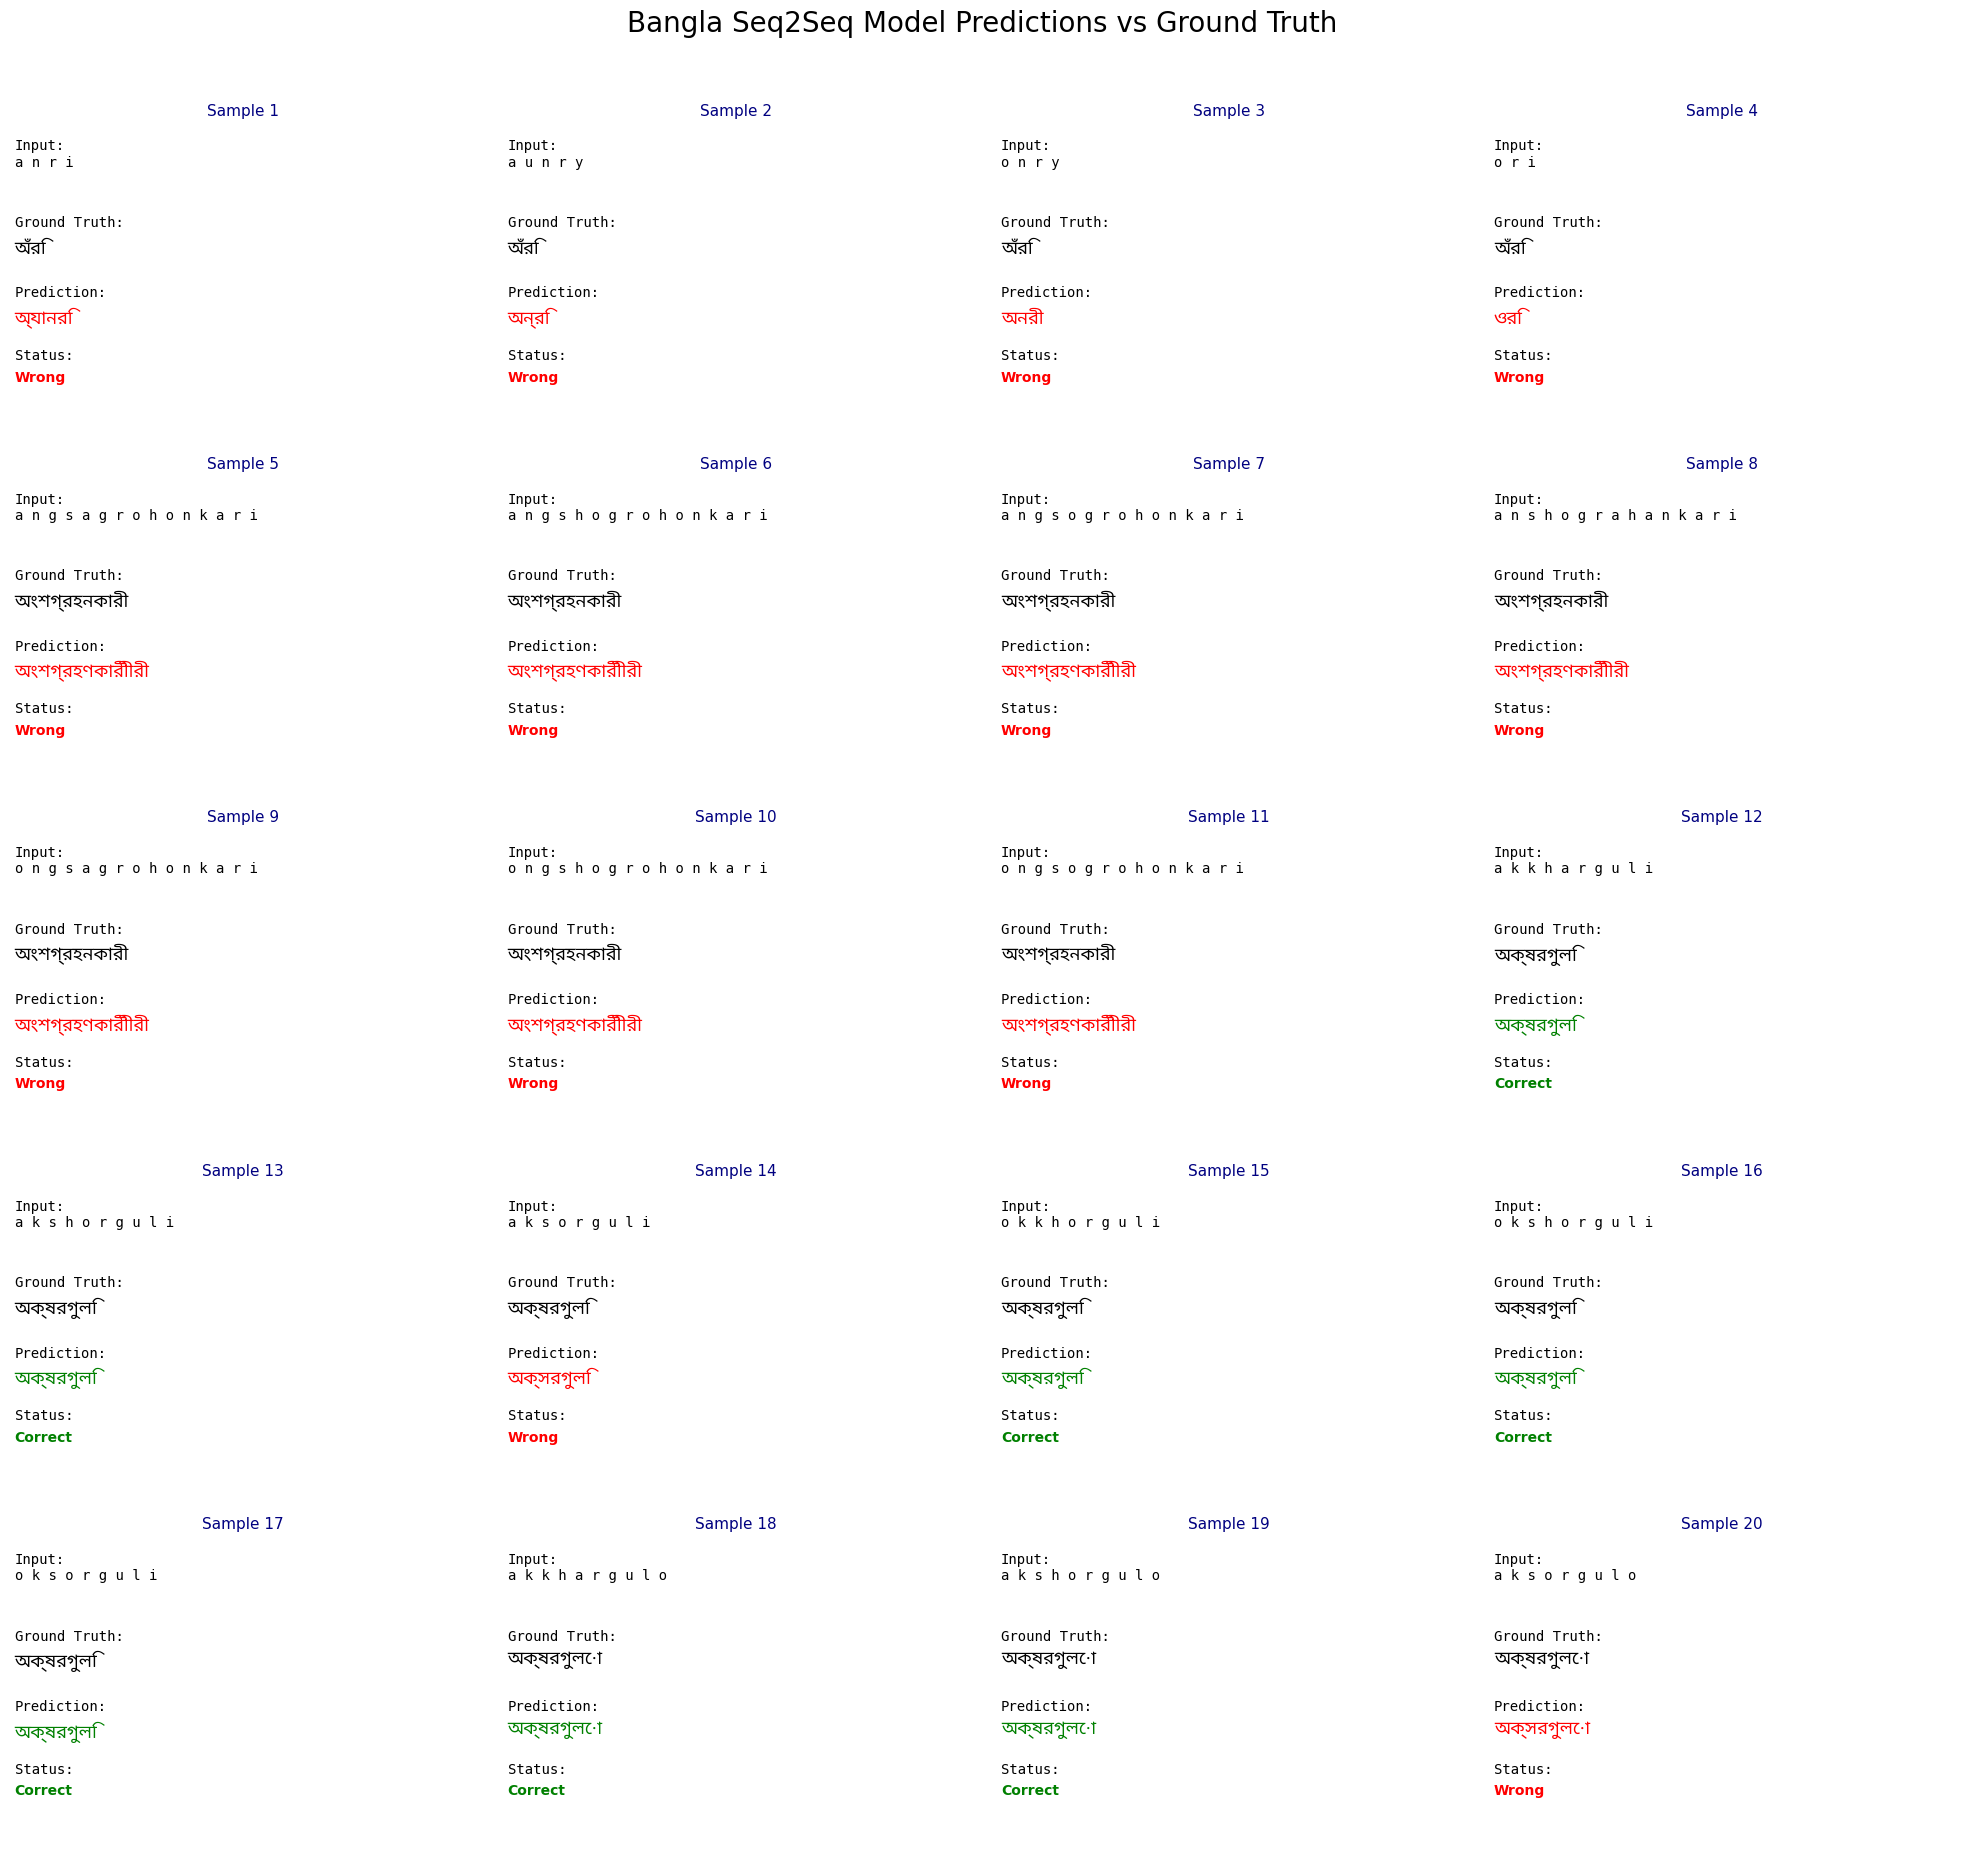

In [ ]:
"""
This code snippet initializes a Weights & Biases (wandb) project named "bangla-seq2seq-eval" 
to track and visualize the performance of a trained sequence-to-sequence (seq2seq) model. 

The function `visualize_predictions_grid` is called to generate a grid of model predictions 
on a test dataset. It takes the trained seq2seq model, a DataLoader containing test samples, 
and vocabulary objects for both input and output languages to decode sequences properly. 

The visualization is performed on the specified device (CPU/GPU), sampling 20 examples 
to provide a representative overview of the model's translation or sequence generation quality. 

Although wandb logging is disabled here (`wandb_log=False`), the initialization and finalization 
calls ensure a clean and structured run environment for future experiments and easy tracking.
"""
# Visualize predictions
wandb.init(project="bangla-seq2seq-eval")

visualize_predictions_grid(
    seq2seq_model=best_seq2seq,
    dataloader=test_dataloader,
    input_vocab=vocab_in,
    output_vocab=vocab_out,
    device=device,
    num_samples=20,
    wandb_log=False
)
wandb.finish()


In [ ]:

def export_predictions_to_file(seq2seq_model, dataloader, input_vocab, output_vocab, device, save_path='test_predictions.csv', show_preview=True):
    idx2input = {v: k for k, v in input_vocab.items()}
    idx2output = {v: k for k, v in output_vocab.items()}

    PAD = "<pad>"
    EOS = "<eos>"
    SOS = "<sos>"

    all_data = []

    seq2seq_model.eval()
    with torch.no_grad():
        for input_batch, target_batch in dataloader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            output = seq2seq_model(input_batch, target_batch, teacher_force_ratio=0)
            _, predicted = torch.max(output, dim=2)

            for i in range(input_batch.size(0)):
                src_seq = [idx2input[token.item()] for token in input_batch[i] if token.item() != input_vocab[PAD]]
                tgt_seq = [idx2output[token.item()] for token in target_batch[i] if token.item() not in [output_vocab[PAD], output_vocab[EOS], output_vocab[SOS]]]
                pred_seq = [idx2output[token.item()] for token in predicted[i] if token.item() not in [output_vocab[PAD], output_vocab[EOS], output_vocab[SOS]]]

                is_correct = pred_seq == tgt_seq
                status = "Correct" if is_correct else "Wrong"

                all_data.append({
                    "Input Sequence": " ".join(src_seq),
                    "Ground Truth": "".join(tgt_seq),
                    "Prediction": "".join(pred_seq),
                    "Status": status
                })

    # Write to CSV
    with open(save_path, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=["Input Sequence", "Ground Truth", "Prediction", "Status"])
        writer.writeheader()
        writer.writerows(all_data)

    print(f"\n Test predictions exported to: {save_path}")



In [ ]:
"""
This code snippet leverages the best-performing sequence-to-sequence (seq2seq) model,
likely enhanced with attention mechanisms, to generate predictions on the test dataset.

- `best_seq2seq`: The trained model that demonstrated optimal performance during validation.
- `test_dataloader`: A PyTorch DataLoader providing batched test data samples.
- `vocab_in` & `vocab_out`: Input and output vocabulary objects used for encoding and decoding sequences.
- `device`: The hardware accelerator (CPU/GPU) where computations are performed.
- `save_path`: The filename specifying where the model's predictions will be saved in CSV format.

The function `export_predictions_to_file` runs inference over the entire test set,
transforms predicted token indices back to human-readable sequences,
and exports these results in a clean CSV file for downstream evaluation or analysis.

This approach streamlines the evaluation process, enabling seamless transition from model outputs 
to accessible prediction records, essential for tasks like translation, transliteration, or sequence generation.
"""
# Use your best model and test dataloader
export_predictions_to_file(best_seq2seq, test_dataloader, vocab_in, vocab_out, device, save_path="test_predictions_with_ATTENTION.csv")



 Test predictions exported to: test_predictions_with_ATTENTION.csv


In [ ]:
def visualize_connectivity(seq2seq_model, dataloader, input_vocab, output_vocab, device, num_samples=3, log_to_wandb=False):

    """
    This function, `visualize_connectivity`, provides a detailed graphical representation of attention mechanisms within a sequence-to-sequence (seq2seq) model's decoder. It takes a trained seq2seq model, a dataloader with input-output pairs, and vocabularies for input and output tokens, then visualizes how decoder attention weights connect each output token to input tokens.

    Key features include:

    - **Language-aware token display:** It attempts to render Bengali tokens using a specified font for accurate script representation.
    - **Custom attention colormap:** Employs a smooth gradient from deep purple to light lavender, visually emphasizing stronger attention weights with deeper hues.
    - **Selective sample visualization:** Processes a user-defined number of samples from the dataloader, ensuring clear, uncluttered plots.
    - **Attention weight extraction:** Runs the model in evaluation mode, performs teacher forcing to obtain decoder attention scores for each output token.
    - **Intuitive plot layout:** Input tokens are displayed at the top, output tokens at the bottom with clear indices; curved connection lines illustrate attention strengths with varying thickness, transparency, and color intensity.
    - **Interactive enhancements:** Adds meaningful labels, colorbars indicating attention magnitude, and titles to improve interpretability.
    - **Integration with Weights & Biases (wandb):** Optionally logs the generated visualization for experiment tracking and sharing.

    This visualization aids in debugging and understanding how the model attends to different input elements when generating outputs, providing insight into model behavior and performance on sequence translation or transliteration tasks.
    """

    
    # Define a function to check if a character is Bengali
    def is_bengali(text):
        # Simple check - can be improved
        return any(ord(c) > 128 for c in text)
    
    # Load Bengali font if available, otherwise use default
    try:
        font_path = "/Users/indramandal/Library/Fonts/NotoSansBengali-Regular.ttf"
        bengali_font = fm.FontProperties(fname=font_path, size=14)
    except:
        bengali_font = None
    
    # Create a custom colormap for attention weights (deep purple to light lavender)
    # Making the high attention colors deeper as requested
    colors = [(0.3, 0, 0.5, 1.0), (0.9, 0.8, 1.0, 0.2)]  # Deeper purple to very light lavender
    cmap = LinearSegmentedColormap.from_list("custom_attention", colors, N=100)
    
    idx2input = {v: k for k, v in input_vocab.items()}
    idx2output = {v: k for k, v in output_vocab.items()}
    
    seq2seq_model.eval()
    samples = []
    
    with torch.no_grad():
        for input_batch, target_batch in dataloader:
            if len(samples) >= num_samples:
                break
                
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            encoder_outputs, hidden, cell = seq2seq_model.encoder(input_batch)
            
            # Adjust hidden dimensions
            encoder_directions = 2 if seq2seq_model.encoder.bidirectional else 1
            decoder_directions = 2 if seq2seq_model.decoder.bidirectional else 1
            encoder_total = seq2seq_model.encoder.num_encod_layers * encoder_directions
            decoder_total = seq2seq_model.decoder.num_layers * decoder_directions
            
            hidden = seq2seq_model.adjust_hidden(hidden, decoder_total)
            cell = seq2seq_model.adjust_hidden(cell, decoder_total) if cell is not None else None
            
            for i in range(input_batch.size(0)):
                if len(samples) >= num_samples:
                    break
                
                # Extract input and target sequences
                input_seq = [idx2input[t.item()] for t in input_batch[i] 
                           if t.item() not in {input_vocab.get("<pad>", -1), 
                                              input_vocab.get("<eos>", -1)}]
                target_seq = [idx2output[t.item()] for t in target_batch[i][1:] 
                             if t.item() not in {output_vocab.get("<pad>", -1), 
                                                output_vocab.get("<eos>", -1)}]
                
                # Collect attention weights
                attention_weights = []
                x = target_batch[i, 0].unsqueeze(0).to(device)
                single_hidden = hidden[:, i:i+1, :].contiguous()
                single_cell = cell[:, i:i+1, :].contiguous() if cell is not None else None
                single_encoder_outputs = encoder_outputs[i:i+1]
                
                for t in range(len(target_seq)):
                    output, single_hidden, single_cell, attn = seq2seq_model.decoder(
                        x, single_hidden, single_encoder_outputs, single_cell)
                    
                    attention_weights.append(attn.squeeze().cpu().numpy())
                    
                    # Teacher forcing for visualization
                    if t+1 < len(target_batch[i]):
                        x = target_batch[i, t+1].unsqueeze(0).to(device)
                    else:
                        break
                
                samples.append({
                    'input': input_seq,
                    'output': target_seq,
                    'attention': np.array(attention_weights)
                })
    
    # Create figure for all samples
    fig = plt.figure(figsize=(15, num_samples * 7))
    
    for idx, sample in enumerate(samples):
        # Create subplot for each sample with more vertical space
        ax = fig.add_subplot(num_samples, 1, idx+1)
        
        # Set up the layout
        input_tokens = sample['input']
        output_tokens = sample['output']
        attention_matrix = sample['attention']
        
        # Define positions with more spacing
        input_y = 0.8
        output_y = 0.2
        x_spacing = 1.0 / (max(len(input_tokens), len(output_tokens)) + 3)
        x_start = x_spacing * 2
        
        # Draw input tokens
        input_positions = []
        for i, token in enumerate(input_tokens):
            x_pos = x_start + i * x_spacing
            input_positions.append(x_pos)
            
            # Box style for input tokens (blue)
            box_style = dict(boxstyle="round,pad=0.3", fc="#d0e0ff", ec="#0066cc", lw=1)
            
            # Display token with index
            ax.text(x_pos, input_y, f"{token}\n[{i}]", 
                   fontproperties=bengali_font if bengali_font and is_bengali(token) else None,
                   ha='center', va='center', bbox=box_style, fontsize=12)
        
        # Draw output tokens
        output_positions = []
        for j, token in enumerate(output_tokens):
            x_pos = x_start + j * x_spacing
            output_positions.append(x_pos)
            
            # Box style for output tokens (green)
            box_style = dict(boxstyle="round,pad=0.3", fc="#d4edda", ec="#155724", lw=1)
            
            # Display token with index
            ax.text(x_pos, output_y, f"{token}\n[{j}]", 
                   fontproperties=bengali_font if bengali_font and is_bengali(token) else None,
                   ha='center', va='center', bbox=box_style, fontsize=12)
        
        # Draw all connections between input and output tokens
        for j, output_pos in enumerate(output_positions):
            if j < len(attention_matrix):
                weights = attention_matrix[j]
                
                # Connect every input token to this output token
                for i, input_pos in enumerate(input_positions):
                    if i < len(weights):
                        # Get weight and normalize it
                        weight = weights[i]
                        
                        # Color based on attention weight - always show connection
                        color = cmap(weight)
                        
                        # Line width based on weight (min 0.5, max 3)
                        linewidth = 0.5 + 2.5 * weight
                        
                        # Draw curved connection - no text labels on lines as requested
                        con = ConnectionPatch(
                            xyA=(input_pos, input_y - 0.05),
                            xyB=(output_pos, output_y + 0.05),
                            coordsA="data",
                            coordsB="data",
                            axesA=ax,
                            axesB=ax,
                            arrowstyle="-",
                            connectionstyle="arc3,rad=0.1",
                            color=color,
                            linewidth=linewidth,
                            alpha=0.3 + 0.7 * weight,  # Vary transparency with weight
                            zorder=0
                        )
                        ax.add_artist(con)
        
        # Add labels with more space
        ax.text(0.05, input_y, "Input", ha='right', va='center', fontsize=14, fontweight='bold')
        ax.text(0.05, output_y, "Output", ha='right', va='center', fontsize=14, fontweight='bold')
        
        # Remove axes
        ax.axis('off')
        
        # Add a colorbar on the right side
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Attention Weight', rotation=270, labelpad=15)
        
        # Add a clear title with more space
        ax.set_title(f"Sample {idx+1} - Decoder Attention Connectivity", 
                    fontsize=16, fontweight='bold', pad=20)
    
    # Add main title with more space to prevent overlap
    plt.suptitle("Seq2Seq Decoder Attention - Attention Pathways", 
                fontsize=20, fontweight='bold', y=0.98)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=3.0)
    
    # Save the figure if needed
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    buf.seek(0)
    img = Image.open(buf)
    
    # Log to wandb if requested
    if log_to_wandb:
        import wandb
        wandb.log({"attention_connectivity": wandb.Image(img)})
    
    plt.show()
    buf.close()


In [28]:
device = torch.device("cpu")
from matplotlib.colors import LinearSegmentedColormap


/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/2077152336.py:190: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=3.0)
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/2077152336.py:190: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Bengali.
  plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=3.0)
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/2077152336.py:194: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_62601/2077152336.py:194: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Bengali.
  plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)


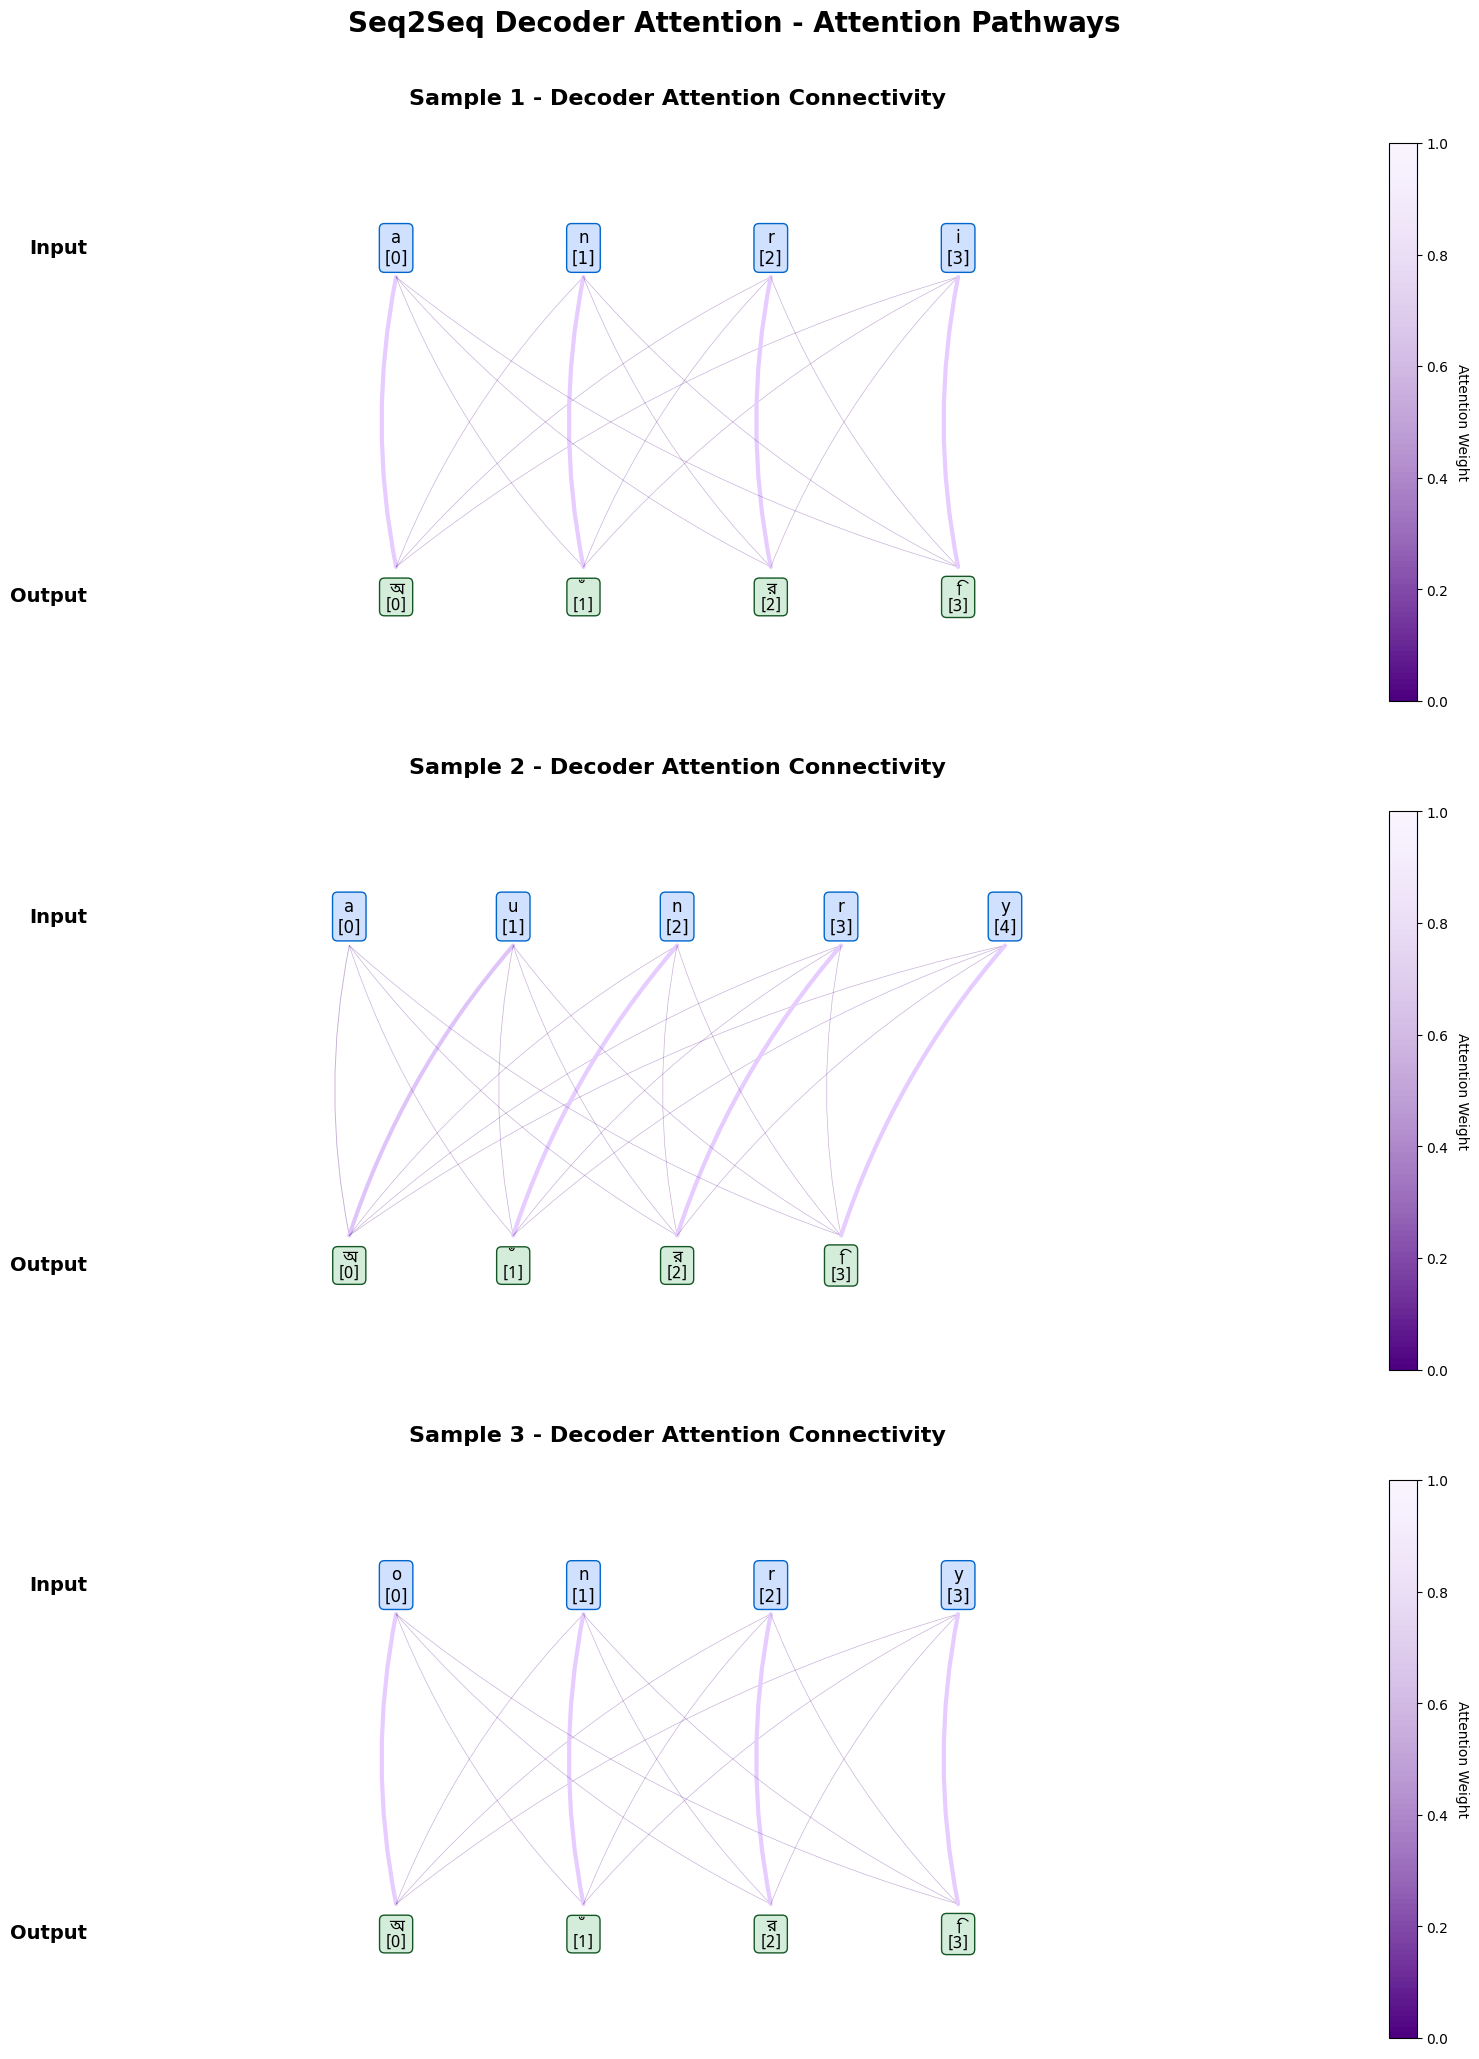

In [ ]:
"""
This code snippet demonstrates the initialization and usage of Weights & Biases (wandb) to log and visualize 
the connectivity of attention weights in a sequence-to-sequence (seq2seq) model with attention mechanisms. 

First, wandb is initialized with a specific project and run name, along with a configuration dictionary 
that provides context about the visualization type ("connectivity") and the model architecture ("seq2seq_with_attention"). 

Next, the function `visualize_connectivity` is called to generate and log attention connectivity visualizations 
using the trained seq2seq model (`best_seq2seq`). It leverages a test data loader, input and output vocabularies, 
and the device (CPU or GPU) on which the model runs. The visualization is restricted to a limited number of samples 
(3 in this case) and is configured to log the outputs directly to wandb for interactive monitoring.

Finally, `wandb.finish()` ensures that the current wandb run is properly closed, which finalizes the logging process 
and uploads all tracked information to the wandb server.

Overall, this code enables detailed insight into the model’s attention behavior during inference, facilitating 
interpretability and debugging of seq2seq attention models through an integrated experiment tracking platform.
"""

# With additional optional parameters
wandb.init(
    project="Attention_weight_visulization_seq2seq", 
    name="attention_connectivity_detailed",
    config={
        "visualization_type": "connectivity",
        "model_type": "seq2seq_with_attention"
    }
)

visualize_connectivity(
    seq2seq_model=best_seq2seq,
    dataloader=test_dataloader,
    input_vocab=vocab_in,
    output_vocab=vocab_out,
    device=device,
    num_samples=3,
    log_to_wandb=True
)

# Don't forget to finish the wandb run when you're done
wandb.finish()
